# Neural Network Project
### Robert Kuprenas
### Student ID: 012611549
### D802 Deep Learning Part 3

## Goal
This notebook builds and trains an image classification convolutional neural network using PyTorch. It also saves a processed dataset file (`processed_data.npz`) and is exported as an executed HTML for submission.

## Files Produced
This project generates the following artifacts as part of the neural network development process:

- `notebook.ipynb`
  The primary Jupyter notebook containing all code for data loading, preprocessing, dataset construction, and verification. The notebook is fully executable from top to bottom without errors.

- `notebook.html`
  An exported, executed version of the notebook that displays all outputs, including printed diagnostics and verification steps. This file serves as the presentation artifact for submission.

- `processed_data.npz`
  A compressed NumPy archive containing the processed dataset metadata used by the model, including:
  - Training and validation image filenames
  - Encoded class labels
  - Class name mappings
  - Image preprocessing parameters

  Image pixel data are stored on disk and referenced by filename to avoid unnecessary duplication and to support reproducibility.

- `data/` directory
  Contains the source image files and CSV-based dataset splits used by the notebook:
  - `data/train/` — image files used for training and validation
  - `data/splits/train_split.csv` — training split metadata
  - `data/splits/val_split.csv` — validation split metadata

- `README.md`
  Describes the project structure, execution steps, and requirements.

- `requirements.txt`
  Lists the Python libraries required to run the notebook.

## Tools/Libraries Used
The following tools and libraries were used to develop and execute this project:

### Development Environment
- PyCharm (Jupyter Notebook support)
  Used as the interactive development environment for writing, executing, and exporting the notebook. PyTorch was selected due to its flexibility, explicit control over data pipelines, and compatibility with the local development environment.

### Core Libraries
- Python 3.11
  Primary programming language for the project.

- PyTorch (`torch`)
  Deep learning framework used for dataset handling, tensor operations, and model development.

- Torchvision (`torchvision`)
  Provides image transformations and utilities for computer vision tasks.

- NumPy (`numpy`)
  Used for numerical operations and for storing the processed dataset in `.npz` format.

- Pandas (`pandas`)
  Used to load and manage CSV files defining training and validation dataset splits.

- Pillow (`PIL`)
  Used for image loading and conversion.

### Supporting Libraries
- pathlib
  Used for robust, cross-platform file and directory path handling.

- os
  Used for environment and filesystem interactions where needed.

## Notebook Setup and Project Path Resolution

This notebook is designed to run reliably across environments by dynamically resolving the project directory at runtime. All file paths used throughout the notebook are derived from this resolved project root to ensure reproducibility and prevent path-related errors.

In [1]:
from pathlib import Path
import os

# The folder this notebook file is in
try:
    NOTEBOOK_DIR = Path(__file__).resolve().parent
except NameError:
    # In notebooks, __file__ may not exist in some environments; fallback:
    NOTEBOOK_DIR = Path.cwd()

print("CWD:", Path.cwd())
print("NOTEBOOK_DIR:", NOTEBOOK_DIR)

# If the project folder is next to the notebook, this will find it
CANDIDATES = [
    NOTEBOOK_DIR / "deep_learning_part3",
    NOTEBOOK_DIR.parent / "deep_learning_part3",
    Path("C:/Users/Robert/Desktop/D802 Part 3/deep_learning_part3"),
]

PROJECT_DIR = next((p for p in CANDIDATES if p.exists()), None)

print("\nProject folder found:", PROJECT_DIR)
if PROJECT_DIR is None:
    raise FileNotFoundError("Could not find deep_learning_part3. We'll set it manually if needed.")

print("\nContents of project folder:")
for p in sorted(PROJECT_DIR.iterdir()):
    kind = "DIR " if p.is_dir() else "FILE"
    print(f"  {kind}  {p.name}")

CWD: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3
NOTEBOOK_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3

Project folder found: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3

Contents of project folder:
  DIR   data
  FILE  notebook.html
  FILE  notebook.ipynb
  FILE  processed_data.npz
  FILE  README.md
  FILE  requirements.txt


## Project Data Directory Configuration

This section defines the locations of all project data directories and files, including image storage and dataset split metadata. These paths serve as the single source for all subsequent data loading and processing steps.

In [2]:
from pathlib import Path

# Source-of-truth paths
DATA_DIR = PROJECT_DIR / "data"
TRAIN_IMAGES_DIR = DATA_DIR / "train"
SPLITS_DIR = DATA_DIR / "splits"

TRAIN_CSV = SPLITS_DIR / "train_split.csv"
VAL_CSV   = SPLITS_DIR / "val_split.csv"
IMAGES_DIR = TRAIN_IMAGES_DIR  # one name to use everywhere

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR, "| exists:", DATA_DIR.exists())
print("IMAGES_DIR:", IMAGES_DIR, "| exists:", IMAGES_DIR.exists())
print("SPLITS_DIR:", SPLITS_DIR, "| exists:", SPLITS_DIR.exists())
print("TRAIN_CSV:", TRAIN_CSV, "| exists:", TRAIN_CSV.exists())
print("VAL_CSV:", VAL_CSV, "| exists:", VAL_CSV.exists())

# Hard fail early if something is off
if not IMAGES_DIR.exists():
    raise FileNotFoundError(f"Images folder not found: {IMAGES_DIR}")
if not TRAIN_CSV.exists() or not VAL_CSV.exists():
    raise FileNotFoundError(f"Split CSVs not found in: {SPLITS_DIR}")

PROJECT_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3
DATA_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data | exists: True
IMAGES_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\train | exists: True
SPLITS_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\splits | exists: True
TRAIN_CSV: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\splits\train_split.csv | exists: True
VAL_CSV: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\splits\val_split.csv | exists: True


## Environment and Dependency Verification

This section reports library versions and verifies that required directories and files are accessible before executing the data pipeline and model code.

In [3]:
import sys
import numpy as np
import pandas as pd
import torch
import torchvision
from pathlib import Path

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)

# Confirm the key paths are still correct
print("\nPROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR:", DATA_DIR, "| exists:", DATA_DIR.exists())
print("IMAGES_DIR:", IMAGES_DIR, "| exists:", IMAGES_DIR.exists())
print("SPLITS_DIR:", SPLITS_DIR, "| exists:", SPLITS_DIR.exists())
print("TRAIN_CSV:", TRAIN_CSV, "| exists:", TRAIN_CSV.exists())
print("VAL_CSV:", VAL_CSV, "| exists:", VAL_CSV.exists())

Python: 3.11.9
NumPy: 2.4.0
Pandas: 2.3.3
Torch: 2.9.1+cpu
Torchvision: 0.24.1+cpu

PROJECT_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3
DATA_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data | exists: True
IMAGES_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\train | exists: True
SPLITS_DIR: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\splits | exists: True
TRAIN_CSV: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\splits\train_split.csv | exists: True
VAL_CSV: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\data\splits\val_split.csv | exists: True


## Dataset Loading and Verification

This section loads the training and validation dataset splits from CSV files and verifies dataset size, class balance, and label structure before model construction.

In [4]:
# Load CSV splits and summarize the dataset
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

print("=== Dataset Summary ===")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

print("\nClass distribution (train):")
print(train_df["label"].value_counts().sort_index())

print("\nClass distribution (validation):")
print(val_df["label"].value_counts().sort_index())

print("\nCSV columns:")
print(train_df.columns.tolist())


=== Dataset Summary ===
Training samples: 45000
Validation samples: 5000

Class distribution (train):
label
airplane      4500
automobile    4500
bird          4500
cat           4500
deer          4500
dog           4500
frog          4500
horse         4500
ship          4500
truck         4500
Name: count, dtype: int64

Class distribution (validation):
label
airplane      500
automobile    500
bird          500
cat           500
deer          500
dog           500
frog          500
horse         500
ship          500
truck         500
Name: count, dtype: int64

CSV columns:
['id', 'filename', 'label', 'label_idx']


## PyTorch Dataset and DataLoader

A custom PyTorch Dataset is defined to load image files using CSV-based labels. DataLoaders are used to batch and shuffle data during training and evaluation.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError

# Preprocessing ("processed" input pipeline)
IMG_SIZE = 224
BATCH_SIZE = 64

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

class CSVImageDataset(Dataset):
    def __init__(self, df, images_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_dir = Path(images_dir)
        self.transform = transform

        # Class names ordered by label_idx
        self.class_names = (
            self.df[["label", "label_idx"]]
            .drop_duplicates()
            .sort_values("label_idx")["label"]
            .tolist()
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.images_dir / str(row["filename"])
        y = int(row["label_idx"])

        try:
            image = Image.open(img_path).convert("RGB")
        except (UnidentifiedImageError, OSError):
            # Skip corrupted/unreadable image by falling back to next index
            new_idx = (idx + 1) % len(self.df)
            row = self.df.iloc[new_idx]
            img_path = self.images_dir / str(row["filename"])
            y = int(row["label_idx"])
            image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, y

train_ds = CSVImageDataset(train_df, IMAGES_DIR, transform=train_tfms)
val_ds   = CSVImageDataset(val_df, IMAGES_DIR, transform=val_tfms)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Class names by index:", train_ds.class_names)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

x, y = next(iter(train_loader))
print("\nBatch x shape:", x.shape)   # expected: (32, 3, 224, 224)
print("Batch y shape:", len(y))      # expected: 32
print("y sample:", y[:10])

Train samples: 45000
Val samples: 5000
Class names by index: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Batch x shape: torch.Size([64, 3, 224, 224])
Batch y shape: 64
y sample: tensor([5, 1, 2, 0, 4, 2, 1, 2, 5, 5])


## Processed Data File Generation

The processed dataset metadata is saved to a compressed NumPy file (`processed_data.npz`). This file contains dataset splits, encoded labels, class mappings, and preprocessing metadata, while image files remain stored on disk.

In [6]:
import numpy as np

# Build class map (ordered by label_idx)
class_map = (
    train_df[["label", "label_idx"]]
    .drop_duplicates()
    .sort_values("label_idx")
)

NPZ_PATH = PROJECT_DIR / "processed_data.npz"

np.savez(
    NPZ_PATH,
    X_train_filenames=train_df["filename"].astype(str).to_numpy(),
    y_train=train_df["label_idx"].astype(np.int64).to_numpy(),
    X_val_filenames=val_df["filename"].astype(str).to_numpy(),
    y_val=val_df["label_idx"].astype(np.int64).to_numpy(),
    class_names=class_map["label"].astype(str).to_numpy(),
    class_indices=class_map["label_idx"].astype(np.int64).to_numpy(),
    img_size=np.array([IMG_SIZE], dtype=np.int32),
    note=np.array(["Images stored in data/train; splits defined by CSVs in data/splits"], dtype=object)
)

print("Saved NPZ:", NPZ_PATH)
print("Train records:", len(train_df), "| Val records:", len(val_df))
print("Classes:", class_map.to_dict(orient="records"))

Saved NPZ: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\processed_data.npz
Train records: 45000 | Val records: 5000
Classes: [{'label': 'airplane', 'label_idx': 0}, {'label': 'automobile', 'label_idx': 1}, {'label': 'bird', 'label_idx': 2}, {'label': 'cat', 'label_idx': 3}, {'label': 'deer', 'label_idx': 4}, {'label': 'dog', 'label_idx': 5}, {'label': 'frog', 'label_idx': 6}, {'label': 'horse', 'label_idx': 7}, {'label': 'ship', 'label_idx': 8}, {'label': 'truck', 'label_idx': 9}]


In [7]:
d = np.load(NPZ_PATH, allow_pickle=True)

print("Loaded:", NPZ_PATH)
print("Keys:", d.files)

print("\nShapes:")
print("X_train_filenames:", d["X_train_filenames"].shape)
print("y_train:", d["y_train"].shape)
print("X_val_filenames:", d["X_val_filenames"].shape)
print("y_val:", d["y_val"].shape)

print("\nMetadata:")
print("img_size:", int(d["img_size"][0]))
print("class_names:", d["class_names"])
print("note:", d["note"][0])

print("\nExample record:")
print(d["X_train_filenames"][0], "->", int(d["y_train"][0]))

Loaded: C:\Users\Robert\Desktop\D802 Part 3\deep_learning_part3\processed_data.npz
Keys: ['X_train_filenames', 'y_train', 'X_val_filenames', 'y_val', 'class_names', 'class_indices', 'img_size', 'note']

Shapes:
X_train_filenames: (45000,)
y_train: (45000,)
X_val_filenames: (5000,)
y_val: (5000,)

Metadata:
img_size: 224
class_names: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
note: Images stored in data/train; splits defined by CSVs in data/splits

Example record:
30769.png -> 1


## Convolutional Neural Network Architecture

This section defines a convolutional neural network (CNN) consisting of convolutional, pooling, and fully connected layers for image classification.

In [8]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 224 -> 112

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 112 -> 56

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model
model = SimpleCNN(num_classes=len(train_ds.class_names))
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Model Forward Pass Verification

A single batch of images is passed through the model to verify that input and output dimensions are correct prior to training.

In [9]:
# Run a forward pass to verify the CNN works end-to-end
model.eval()  # evaluation mode

with torch.no_grad():
    images, labels = next(iter(train_loader))
    outputs = model(images)

print("Input batch shape:", images.shape)     # (batch_size, 3, 224, 224)
print("Output shape:", outputs.shape)          # (batch_size, num_classes)
print("Sample output (first row):")
print(outputs[0])

Input batch shape: torch.Size([64, 3, 224, 224])
Output shape: torch.Size([64, 10])
Sample output (first row):
tensor([-0.0526, -0.0062,  0.0607,  0.0015,  0.0579, -0.0557,  0.0042, -0.0353,
         0.0020,  0.0159])


## Model Summary and Parameter Analysis

This section summarizes the neural network architecture, including layer output shapes and the total number of trainable parameters.

In [10]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", f"{total_params:,}")
print("Trainable parameters:", f"{trainable_params:,}")

# Optional: show parameters per major block (features vs classifier)
features_params = sum(p.numel() for p in model.features.parameters())
classifier_params = sum(p.numel() for p in model.classifier.parameters())

print("\nBreakdown:")
print(" - features params:", f"{features_params:,}")
print(" - classifier params:", f"{classifier_params:,}")

Total parameters: 25,786,186
Trainable parameters: 25,786,186

Breakdown:
 - features params: 93,248
 - classifier params: 25,692,938


In [11]:
from torchinfo import summary

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params"),
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SimpleCNN                                [1, 3, 224, 224]          [1, 10]                   --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 128, 28, 28]          --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
│    └─ReLU: 2-5                         [1, 64, 112, 112]         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 64, 112, 112]         [1, 64, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           [1, 128, 56, 56]          73,856
│    └─ReLU: 2-8          

# PART 4 EVALUATION B and C

# 4B: Early Stopping

In [12]:
import copy
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Device: cpu


In [13]:
class EarlyStopping:
    """
    Stops training when validation loss doesn't improve after `patience` epochs.
    Saves best model weights (lowest val loss).
    """
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.best_state = None
        self.counter = 0

    def step(self, val_loss, model):
        improved = val_loss < (self.best_loss - self.min_delta)
        if improved:
            self.best_loss = val_loss
            self.best_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience  # True => stop

In [14]:
def run_one_epoch(model, loader, criterion, optimizer=None):
    """
    If optimizer is provided -> train mode; otherwise -> eval mode.
    Returns: (avg_loss, accuracy)
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(is_train):
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


# --- Training with stopping criteria ---
MAX_EPOCHS = 20
early_stopper = EarlyStopping(patience=5, min_delta=0.0)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, MAX_EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, criterion, optimizer=optimizer)
    val_loss, val_acc = run_one_epoch(model, val_loader, criterion, optimizer=None)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
        f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
    )

    should_stop = early_stopper.step(val_loss, model)
    if should_stop:
        print(f"Early stopping triggered at epoch {epoch}. Best val_loss={early_stopper.best_loss:.4f}")
        break

# Restore best weights
if early_stopper.best_state is not None:
    model.load_state_dict(early_stopper.best_state)

final_epoch_ran = len(history["train_loss"])
print("Final training epoch completed:", final_epoch_ran)

Epoch 01/20 | train_loss=1.5976 train_acc=0.4217 | val_loss=1.3666 val_acc=0.4988
Epoch 02/20 | train_loss=1.2827 train_acc=0.5407 | val_loss=1.1783 val_acc=0.5788
Epoch 03/20 | train_loss=1.1379 train_acc=0.5918 | val_loss=1.1006 val_acc=0.6042
Epoch 04/20 | train_loss=1.0421 train_acc=0.6256 | val_loss=1.0527 val_acc=0.6320
Epoch 05/20 | train_loss=0.9589 train_acc=0.6587 | val_loss=0.9859 val_acc=0.6614
Epoch 06/20 | train_loss=0.8925 train_acc=0.6821 | val_loss=1.0028 val_acc=0.6476
Epoch 07/20 | train_loss=0.8165 train_acc=0.7106 | val_loss=0.9873 val_acc=0.6546
Epoch 08/20 | train_loss=0.7528 train_acc=0.7340 | val_loss=1.0003 val_acc=0.6688
Epoch 09/20 | train_loss=0.6856 train_acc=0.7571 | val_loss=1.0165 val_acc=0.6720
Epoch 10/20 | train_loss=0.6229 train_acc=0.7803 | val_loss=0.9775 val_acc=0.6788
Epoch 11/20 | train_loss=0.5591 train_acc=0.8026 | val_loss=1.0123 val_acc=0.6768
Epoch 12/20 | train_loss=0.5104 train_acc=0.8195 | val_loss=1.0565 val_acc=0.6676
Epoch 13/20 | tr

# 4C1: Loss Curves

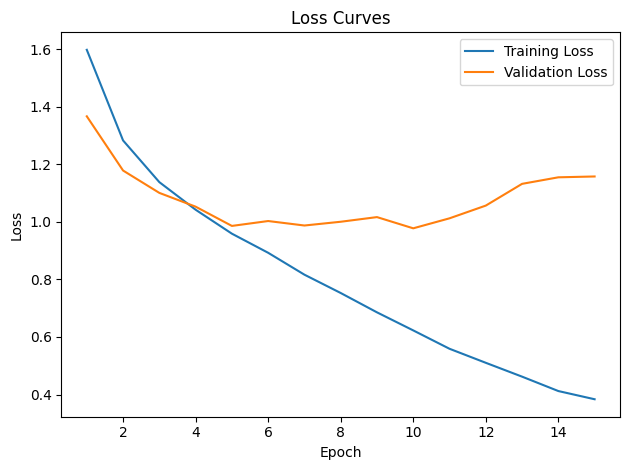

Saved: loss_curves.png


In [15]:
import matplotlib.pyplot as plt

epochs_ran = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_ran, history["train_loss"], label="Training Loss")
plt.plot(epochs_ran, history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs_ran, history["train_loss"], label="Training Loss")
plt.plot(epochs_ran, history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=200)
plt.close()

print("Saved: loss_curves.png")

# 4C2: Accuracy Curves

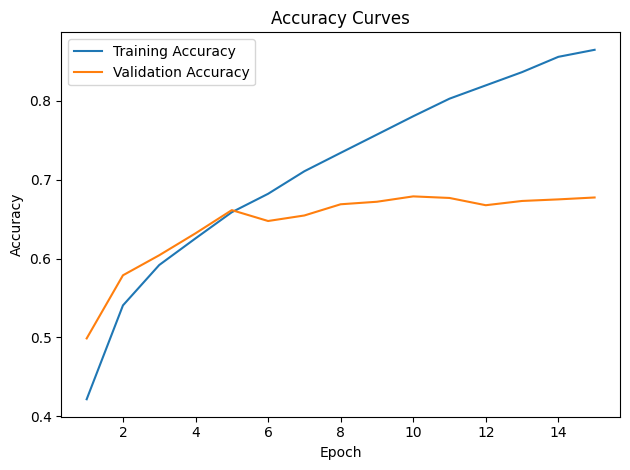

Saved: accuracy_curves.png


In [16]:
import matplotlib.pyplot as plt

epochs_ran = range(1, len(history["train_acc"]) + 1)

plt.figure()
plt.plot(epochs_ran, history["train_acc"], label="Training Accuracy")
plt.plot(epochs_ran, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs_ran, history["train_acc"], label="Training Accuracy")
plt.plot(epochs_ran, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curves.png", dpi=200)
plt.close()

print("Saved: accuracy_curves.png")

# 4C3: Confusion Matrix (Validation)

<Figure size 800x800 with 0 Axes>

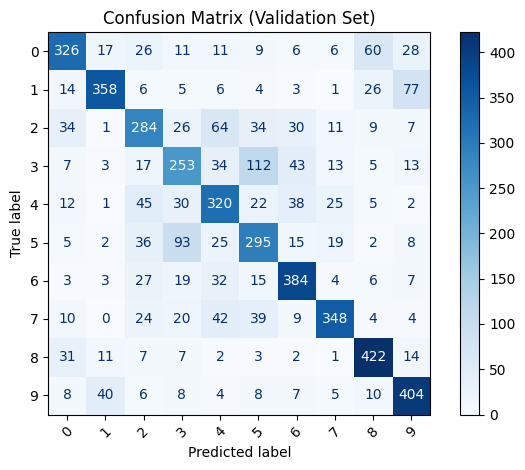

Saved: confusion_matrix_val.png


<Figure size 800x800 with 0 Axes>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.savefig("confusion_matrix_val.png", dpi=200)
plt.close()

print("Saved: confusion_matrix_val.png")

## Confirm Class Balance Counts

In [18]:
unique, counts = np.unique(all_labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(500), np.int64(1): np.int64(500), np.int64(2): np.int64(500), np.int64(3): np.int64(500), np.int64(4): np.int64(500), np.int64(5): np.int64(500), np.int64(6): np.int64(500), np.int64(7): np.int64(500), np.int64(8): np.int64(500), np.int64(9): np.int64(500)}
